In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
!git clone https://github.com/spMohanty/PlantVillage-Dataset.git

Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163235, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 163235 (delta 2), reused 1 (delta 0), pack-reused 163229 (from 1)
Receiving objects: 100% (163235/163235), 2.00 GiB | 58.92 MiB/s, done.
Resolving deltas: 100% (101/101), done.
Updating files: 100% (182401/182401), done.


In [ ]:
import requests
from pathlib import Path

source_path = Path("PlantVillage-Dataset/raw/color")

import os

for dirpath, dirnames, filenames in os.walk(source_path):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
# print(filenames)
print(source_path)

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Your source directory — where all class folders currently live
source_dir = source_path

# Destination root for train and test
dest_dir = "/content/plantvillage"
train_dir = os.path.join(dest_dir, "train")
test_dir = os.path.join(dest_dir, "test")

# Create train/test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Loop through each class folder
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue  # skip files if any

    # Get all images in the class folder
    images = [f for f in os.listdir(class_path) if f.endswith(('.JPG', '.JPEG', '.PNG'))]

    # Full paths to images

    images_full_path = [os.path.join(class_path, f) for f in images]
    # Train-test split
    train_imgs, test_imgs = train_test_split(images_full_path, test_size=0.2, random_state=42)

    # Create class subfolders in train/test directories
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Move train images
    for img_path in train_imgs:
        shutil.copy(img_path, os.path.join(train_dir, class_name, os.path.basename(img_path)))

    # Move test images
    for img_path in test_imgs:
        shutil.copy(img_path, os.path.join(test_dir, class_name, os.path.basename(img_path)))

print("✅ Done! Your dataset is now split and organized.")

In [ ]:
image_path = Path("plantvillage")

total=[]
for dirpath, dirnames, filenames in os.walk(image_path):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
  total.append(len(filenames))

print(sum(total))

In [ ]:
import random
from PIL import Image
import matplotlib.pyplot as plt
image_path_list = list(image_path.glob("*/*/*.JPG"))
random_image_path = random.choice(image_path_list)

print(random_image_path)

image_class = random_image_path.parent.stem
image_class
img = Image.open(random_image_path)
plt.imshow(img)
print(f"Image Class: {image_class} | Height: {img.height} | Width: {img.width}")

In [ ]:
data_path = Path("plantvillage")
train_dir = data_path / "train"

test_dir = data_path / "test"

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


train_data_transform = transforms.Compose([transforms.Resize(size=(128,128)),
                                           transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.2),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
                                     transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                    transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)])

test_data_transform= transforms.Compose([transforms.Resize(size=(128,128)),
                                    transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)])

train_data = datasets.ImageFolder(root=train_dir,
                                  transform = train_data_transform)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform = test_data_transform)

len(test_data), len(train_data)

In [ ]:
from torch.utils.data import DataLoader
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(dataset = train_data,
                             shuffle=True,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS)
test_dataloader = DataLoader(dataset=test_data,
                              shuffle=False,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS)

image, label = next(iter(test_dataloader))
print(f"Shape: {image.shape}")
print(f"Label: {label}")

train_data

In [ ]:
class_names = train_data.classes
class_dict = train_data.class_to_idx
print(f"Classes: {class_names}")
print(f"Number of classes: {len(class_names)}")
print(f"Dict: {class_dict}")
random_idx = torch.randint(0, len(class_names), size=[1]).item()
img, label = train_data[random_idx]
plt.imshow(img.permute(1,2,0));

In [ ]:
from torch import nn
class PlantVillageModelV0(nn.Module):
  def __init__(self, input_shape: int,
               output_shape: int,
               hidden_units: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(nn.Conv2d(input_shape,
                                                hidden_units,
                                                kernel_size=3,
                                                padding=1,
                                                stride=1),
                                      nn.BatchNorm2d(hidden_units),
                                      nn.ReLU(),
                                      nn.Conv2d(hidden_units,
                                                hidden_units,
                                                kernel_size=3,
                                                padding=1,
                                                stride=1),
                                      nn.BatchNorm2d(hidden_units),
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=2))
    self.conv_block_2 = nn.Sequential(nn.Conv2d(hidden_units,
                                                 hidden_units*2,
                                                 kernel_size=3,
                                                 padding=1,
                                                 stride=1),
                                      nn.BatchNorm2d(hidden_units*2),
                                      nn.ReLU(),
                                      nn.Conv2d(hidden_units*2,
                                                hidden_units*2,
                                                kernel_size=3,
                                                padding=1,
                                                stride=1),
                                      nn.BatchNorm2d(hidden_units*2),
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=2))
    self.classifier = nn.Sequential(nn.Flatten(),
                                   nn.Dropout(0.3),
                                   nn.Linear(hidden_units*2*32*32,
                                             output_shape))

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

model_0 = PlantVillageModelV0(input_shape=3, output_shape=38, hidden_units=32).to(device)
model_0

In [ ]:
from torch import nn
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(lr=1e-3, params=model_0.parameters(),weight_decay=1e-4)

from tqdm.auto import tqdm

# Measure time
from timeit import default_timer as timer
start_time = timer()

torch.manual_seed(42)

epochs = 10

model_0.train()

results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

for epoch in tqdm(range(epochs)):
  y_preds= []
  train_loss, train_acc = 0, 0
  test_loss, test_acc = 0,0
  print(f"Epoch: {epoch}\n---------")
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)
    y_logits = model_0(X)
    loss = loss_fn(y_logits, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_labels = y_logits.argmax(dim=1)
    train_acc += (y_labels==y).sum().item()/len(y_logits)

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  model_0.eval()

  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(test_dataloader):
      X_test, y_test = X_test.to(device), y_test.to(device)
      test_y_logits = model_0(X_test)
      loss = loss_fn(test_y_logits, y_test)
      test_loss += loss.item()

      test_y_labels = test_y_logits.argmax(dim=1)
      y_preds.append(test_y_labels.cpu())
      test_acc += (test_y_labels == y_test).sum().item()/len(test_y_logits)
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

    print(f"Train Loss: {train_loss} | Train Acc: {train_acc}")
    print(f"Test Loss: {test_loss} | Test Acc: {test_acc}")

  y_pred_tensor = (torch.cat(y_preds))
  results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
  results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
  results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
  results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
# Get the loss values of the results dictionary(training and test)
loss = results["train_loss"]
test_loss = results["test_loss"]

# Get the accuracy values of the results dictionary (training and test)
accuracy = results["train_acc"]
test_accuracy = results["test_acc"]

# Figure out how many epochs there were
epochs = range(len(results["train_loss"]))

# Setup a plot
plt.figure(figsize=(15, 7))

# Plot the loss
plt.subplot(1,2,1)
plt.plot(epochs, loss, label="train_loss")
plt.plot(epochs, test_loss, label="test_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend();

# Plot the accuracy
plt.subplot(1,2,2)
plt.plot(epochs, accuracy, label="train_accuracy")
plt.plot(epochs, test_accuracy, label="test_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend();



In [ ]:
# See if required packages arre installed and if not, install them
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1] >= 19, "mlxtend version should be 0.19.0 or higher")
except:
  !pip install torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and ccompare predictions to targets
confmat = ConfusionMatrix(num_classes = len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=(torch.tensor(test_data.targets)).squeeze())

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), # matplotlib likes working with numpy
                                class_names=class_names,
                                figsize=(10, 7))

model v1

There are 38 directories and 0 images in 'PlantVillage-Dataset/raw/color'.
There are 0 directories and 1478 images in 'PlantVillage-Dataset/raw/color/Pepper,_bell___healthy'.
There are 0 directories and 1000 images in 'PlantVillage-Dataset/raw/color/Potato___Early_blight'.
There are 0 directories and 1676 images in 'PlantVillage-Dataset/raw/color/Tomato___Spider_mites Two-spotted_spider_mite'.
There are 0 directories and 1404 images in 'PlantVillage-Dataset/raw/color/Tomato___Target_Spot'.
There are 0 directories and 373 images in 'PlantVillage-Dataset/raw/color/Tomato___Tomato_mosaic_virus'.
There are 0 directories and 1909 images in 'PlantVillage-Dataset/raw/color/Tomato___Late_blight'.
There are 0 directories and 1591 images in 'PlantVillage-Dataset/raw/color/Tomato___healthy'.
There are 0 directories and 854 images in 'PlantVillage-Dataset/raw/color/Cherry_(including_sour)___healthy'.
There are 0 directories and 1180 images in 'PlantVillage-Dataset/raw/color/Grape___Black_rot'.
The

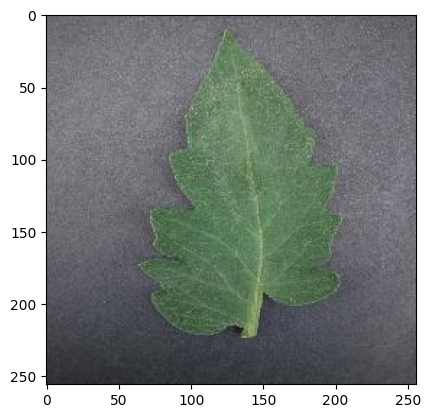

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

import requests
from pathlib import Path

source_path = Path("PlantVillage-Dataset/raw/color")

import os

for dirpath, dirnames, filenames in os.walk(source_path):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
# print(filenames)
print(source_path)


import os
import shutil
from sklearn.model_selection import train_test_split

# Your source directory — where all class folders currently live
source_dir = source_path

# Destination root for train and test
dest_dir = "/content/plantvillage"
train_dir = os.path.join(dest_dir, "train")
test_dir = os.path.join(dest_dir, "test")

# Create train/test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Loop through each class folder
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue  # skip files if any

    # Get all images in the class folder
    images = [f for f in os.listdir(class_path) if f.endswith(('.JPG', '.JPEG', '.PNG'))]

    # Full paths to images

    images_full_path = [os.path.join(class_path, f) for f in images]
    # Train-test split
    train_imgs, test_imgs = train_test_split(images_full_path, test_size=0.2, random_state=42, shuffle=False)

    # Create class subfolders in train/test directories
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Move train images
    for img_path in train_imgs:
        shutil.copy(img_path, os.path.join(train_dir, class_name, os.path.basename(img_path)))

    # Move test images
    for img_path in test_imgs:
        shutil.copy(img_path, os.path.join(test_dir, class_name, os.path.basename(img_path)))

print("✅ Done! Your dataset is now split and organized.")

image_path = Path("plantvillage")

total=[]
for dirpath, dirnames, filenames in os.walk(image_path):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
  total.append(len(filenames))

print(sum(total))


import random
from PIL import Image
import matplotlib.pyplot as plt
image_path_list = list(image_path.glob("*/*/*.JPG"))
random_image_path = random.choice(image_path_list)

print(random_image_path)

image_class = random_image_path.parent.stem
image_class
img = Image.open(random_image_path)
plt.imshow(img)
print(f"Image Class: {image_class} | Height: {img.height} | Width: {img.width}")


In [ ]:
data_path = Path("plantvillage")
train_dir = data_path / "train"

test_dir = data_path / "test"

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


train_data_transform = transforms.Compose([transforms.Resize(size=(256,256)),
                                           transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.2),
                                           transforms.RandomResizedCrop(224),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
                                     transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                    transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
                                           ])

test_data_transform= transforms.Compose([transforms.Resize(size=(256,256)),
                                    transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)])

train_data = datasets.ImageFolder(root=train_dir,
                                  transform = train_data_transform)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform = test_data_transform)

len(test_data), len(train_data)

(19004, 50653)

Shape: torch.Size([32, 3, 256, 256])
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tom

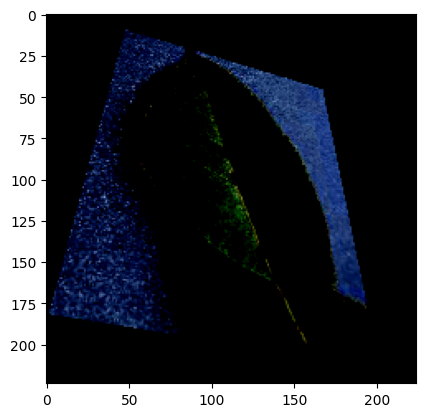

In [ ]:
from torch.utils.data import DataLoader
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(dataset = train_data,
                             shuffle=True,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                              pin_memory=True)
test_dataloader = DataLoader(dataset=test_data,
                              shuffle=False,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                             pin_memory=True)

image, label = next(iter(test_dataloader))
print(f"Shape: {image.shape}")
print(f"Label: {label}")

train_data

class_names = train_data.classes
class_dict = train_data.class_to_idx
print(f"Classes: {class_names}")
print(f"Number of classes: {len(class_names)}")
print(f"Dict: {class_dict}")
random_idx = torch.randint(0, len(class_names), size=[1]).item()
img, label = train_data[random_idx]
plt.imshow(img.permute(1,2,0));

In [ ]:
device= "cuda" if torch.cuda.is_available() else "cpu"

from torch import nn
from torchvision.models import resnet18

model_1 = resnet18(weights=None)

model_1.fc = torch.nn.Linear(in_features=512, out_features=len(class_names)).to(device)

model_1.fc

model_1.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
device= "cuda" if torch.cuda.is_available() else "cpu"
from torch import nn
from torch.optim.lr_scheduler import OneCycleLR
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(lr=1e-3, params=model_1.parameters(), weight_decay=1e-4)

# scheduler = OneCycleLR(optimizer, epochs=8, max_lr=0.01, steps_per_epoch=len(train_dataloader)) # halvve LR every 5 epochs

from tqdm.auto import tqdm

# Measure time
from timeit import default_timer as timer
start_time = timer()

torch.manual_seed(42)

epochs = 5

model_1.train()

results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

for epoch in tqdm(range(epochs)):
  y_preds= []
  train_loss, train_acc = 0, 0
  test_loss, test_acc = 0,0
  print(f"Epoch: {epoch}\n---------")
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)
    y_logits = model_1(X)
    loss = loss_fn(y_logits, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # scheduler.step()
    y_labels = y_logits.argmax(dim=1)
    train_acc += (y_labels==y).sum().item()/len(y_logits)

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  model_1.eval()

  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(test_dataloader):
      X_test, y_test = X_test.to(device), y_test.to(device)
      test_y_logits = model_1(X_test)
      loss = loss_fn(test_y_logits, y_test)
      test_loss += loss.item()

      test_y_labels = test_y_logits.argmax(dim=1)
      y_preds.append(test_y_labels.cpu())
      test_acc += (test_y_labels == y_test).sum().item()/len(test_y_logits)
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

    print(f"Train Loss: {train_loss} | Train Acc: {train_acc}")
    print(f"Test Loss: {test_loss} | Test Acc: {test_acc}")

  y_pred_tensor = (torch.cat(y_preds))
  results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
  results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
  results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
  results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train Loss: 1.4490063066958478 | Train Acc: 0.5820667327422834
Test Loss: 0.6029216950000437 | Test Acc: 0.8017676767676768
Epoch: 1
---------
Train Loss: 1.1862448622023691 | Train Acc: 0.6507061831528961
Test Loss: 0.49421067035565724 | Test Acc: 0.8393759018759019
Epoch: 2
---------
Train Loss: 1.027403044516123 | Train Acc: 0.6932024255560154
Test Loss: 0.394958413485908 | Test Acc: 0.875368265993266
Epoch: 3
---------
Train Loss: 0.9671645536312783 | Train Acc: 0.7123593624066046
Test Loss: 0.29950373219769066 | Test Acc: 0.9015151515151515
Epoch: 4
---------
Train Loss: 0.9235802857806542 | Train Acc: 0.7258029821160171
Test Loss: 0.3361670323697045 | Test Acc: 0.891196188071188
Total training time: 450.652 seconds


In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "PlantVillageModelV4.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f = MODEL_SAVE_PATH)

Saving model to: models/PlantVillageModelV4.pth


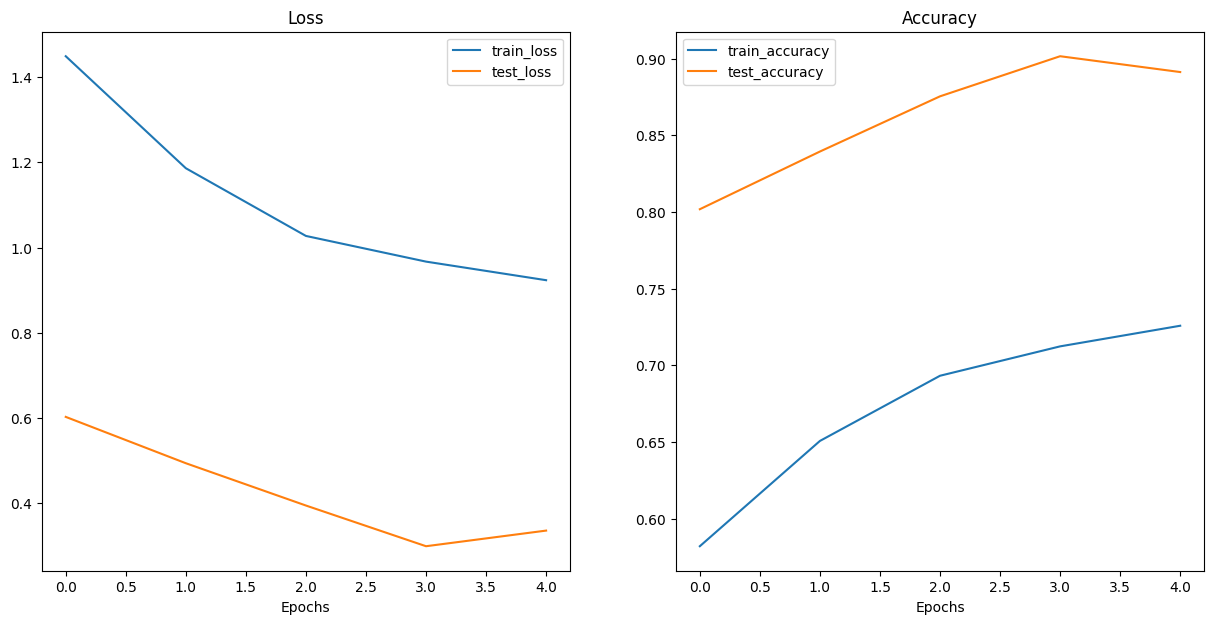

In [ ]:
# Get the loss values of the results dictionary(training and test)
loss = results["train_loss"]
test_loss = results["test_loss"]

# Get the accuracy values of the results dictionary (training and test)
accuracy = results["train_acc"]
test_accuracy = results["test_acc"]

# Figure out how many epochs there were
epochs = range(len(results["train_loss"]))

# Setup a plot
plt.figure(figsize=(15, 7))

# Plot the loss
plt.subplot(1,2,1)
plt.plot(epochs, loss, label="train_loss")
plt.plot(epochs, test_loss, label="test_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend();

# Plot the accuracy
plt.subplot(1,2,2)
plt.plot(epochs, accuracy, label="train_accuracy")
plt.plot(epochs, test_accuracy, label="test_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend();

In [ ]:
# See if required packages arre installed and if not, install them
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1] >= 19, "mlxtend version should be 0.19.0 or higher")
except:
  !pip install torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

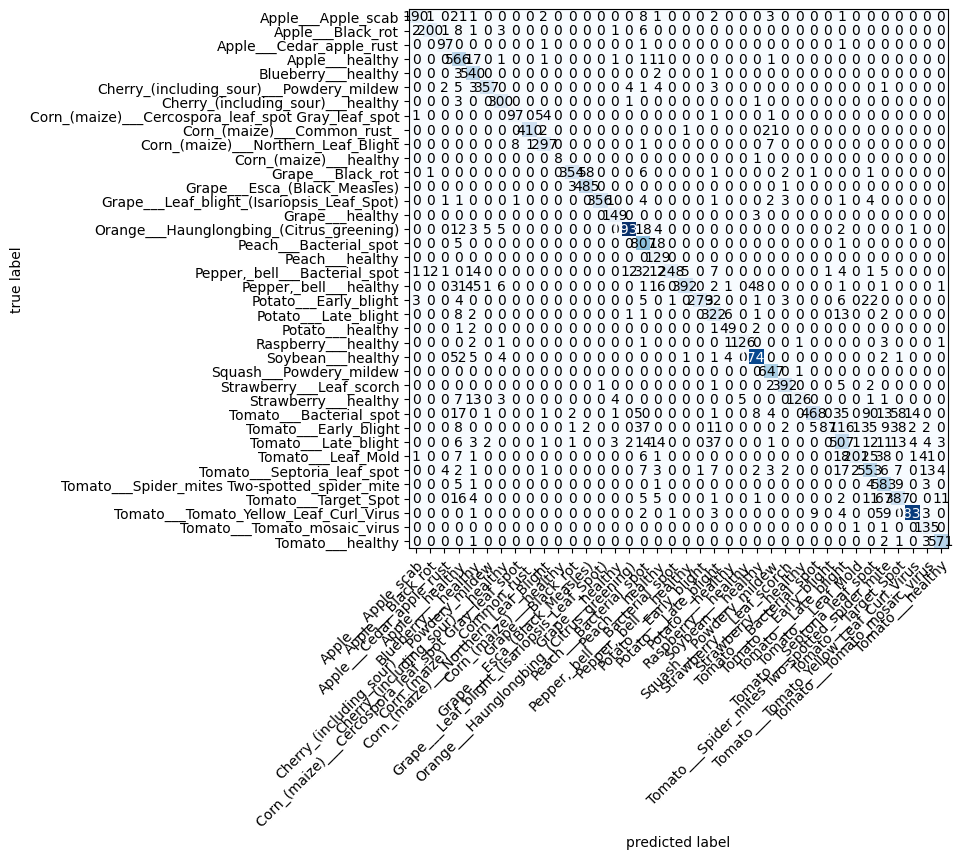

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and ccompare predictions to targets
confmat = ConfusionMatrix(num_classes = len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=(torch.tensor(test_data.targets)).squeeze())

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), # matplotlib likes working with numpy
                                class_names=class_names,
                                figsize=(10, 7))

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=f173e4a4f7817a0ac4e5c39b4c90123d398cb3427d1b72722821a7662bcd4496
  Stored in directory: /root/.cache/pip/wheels/bc/52/78/893c3b94279ef238f43a9e89608af648de401b96415bebbd1f
Successfully built grad-cam


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/data/Done/Potato__Early_blight/potato-blight-leaf.jpg'

In [ ]:
import requests
from pathlib import Path
import os

from google.colab import drive
drive.mount('/content/drive')

image_path =  Path("/content/drive/My Drive/data")


from torchvision import transforms
from PIL import Image

model_1.eval()
image_path = Path("/content/drive/My Drive/data/Done/Strawberry___Leaf_scorch/images.jpg")
image = Image.open(image_path)
transform = transforms.Compose([transforms.Resize(size=(224,224)),
                                transforms.ToTensor()])

input_tensor=transform(image).unsqueeze(0)
print(f"Input shape: {input_tensor.shape}")

y_logits_test = model_1(input_tensor.to(device))

print(f"Predicted class: {class_names[y_logits_test.argmax(dim=1)]}")
#print(f"Probability: {(torch.softmax(y_logits_test, dim=1))[y_logits_test.argmax(dim=1)]}")

input_tensor.to(device)

import numpy as np
import matplotlib.pyplot as plt
# Original image must be in [0,1] for overlay
rgb_img = np.array(image.resize((224, 224))).astype(np.float32) / 255.0

plt.imshow(rgb_img)
plt.axis(False);

from torchvision.models import resnet18
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layer = model_1.layer4[-1]
gradcam = GradCAMPlusPlus(model_1, target_layers=[target_layer])

grayscale_cam = gradcam(input_tensor=input_tensor, targets=None, aug_smooth=True, eigen_smooth=True)
grayscale_cam = grayscale_cam[0]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

import matplotlib.pyplot as plt

plt.imshow(rgb_img)

plt.imshow(visualization)
plt.axis(False)
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Input shape: torch.Size([1, 3, 224, 224])


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Loaded model

In [ ]:
import torch
from torchvision.models import resnet18
device = "cuda" if torch.cuda.is_available() else "cpu"
model_loaded = resnet18(weights=None)
model_loaded.fc = torch.nn.Linear(in_features=512, out_features=38)
model_loaded.load_state_dict(torch.load("PlantVillageModelV4.pth"))
model_loaded.eval()
model_loaded.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from google.colab import drive
from pathlib import Path
drive.mount("/content/drive")
image_path = Path("/content/drive/My Drive/data")
image_path = Path("/content/drive/My Drive/data/Done")


Mounted at /content/drive


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Your source directory — where all class folders currently live

# Destination root for train and test
dest_dir = "/content/ReadWorldTest"
train_dir = os.path.join(dest_dir, "train")
test_dir = os.path.join(dest_dir, "test")

# Create train/test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Loop through each class folder
for class_name in os.listdir(image_path):
    class_path = os.path.join(image_path, class_name)
    if not os.path.isdir(class_path):
        continue  # skip files if any

    # Get all images in the class folder
    images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png', 'webp'))]

    # Full paths to images
    images_full_path = [os.path.join(class_path, f) for f in images]

    # Train-test split
    train_imgs, test_imgs = train_test_split(images_full_path, test_size=0.2, train_size=0.8, random_state=42, shuffle=False)

    # Create class subfolders in train/test directories
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Move train images
    for img_path in train_imgs:
        shutil.copy(img_path, os.path.join(train_dir, class_name, os.path.basename(img_path)))

    # Move test images
    for img_path in test_imgs:
        shutil.copy(img_path, os.path.join(test_dir, class_name, os.path.basename(img_path)))

print("✅ Done! Your dataset is now split and organized.")

✅ Done! Your dataset is now split and organized.


Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomat

Shape: torch.Size([2, 3, 224, 224])


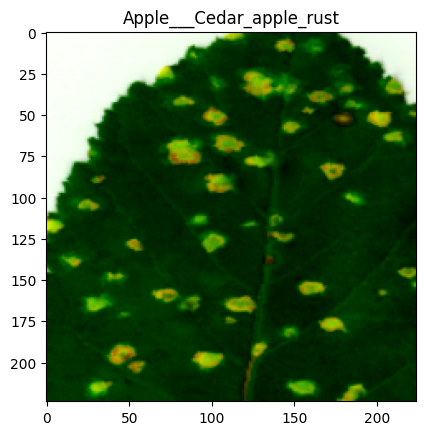

In [ ]:
data_path = Path("ReadWorldTest")
train_dir = data_path / "train"
test_dir = data_path / "test"

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt


train_data_transform = transforms.Compose([transforms.Resize(size=(256,256)),
                                           transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.2),
                                           transforms.RandomResizedCrop(224),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
                                     transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                    transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
                                           ])

test_data_transform= transforms.Compose([transforms.Resize(size=(256,256)),
                                    transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)])

train_data = datasets.ImageFolder(root=train_dir,
                                  transform = train_data_transform)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform = test_data_transform)

len(test_data), len(train_data)

from torch.utils.data import DataLoader
import os
BATCH_SIZE = 2
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(dataset = train_data,
                             shuffle=True,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                              pin_memory=True)
test_dataloader = DataLoader(dataset=test_data,
                              shuffle=False,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                             pin_memory=True)

class_names = train_data.classes
print(f"Class names: {class_names}")
print(f"Number of classes: {len(class_names)}")
image, label = next(iter(train_dataloader))
print(f"Shape: {image.shape}")
random_idx = torch.randint(0, len(class_names), size=[1]).item()
# print(train_data[random_idx])
image, label = train_data[random_idx]
plt.imshow(image.permute(1,2,0));
plt.title(class_names[label]);

In [ ]:
device= "cuda" if torch.cuda.is_available() else "cpu"
from torch import nn
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(lr=1e-4, params=model_loaded.parameters(), weight_decay=1e-4)

scheduler = ReduceLROnPlateau(optimizer,
                              mode="min", # because we're monitoring validation loss
                              patience=3, # wait 3 epochs before reducing
                              factor=0.5, # halve the LR
                              verbose=True)  # print update
# scheduler = OneCycleLR(optimizer, epochs=8, max_lr=0.01, steps_per_epoch=len(train_dataloader)) # halvve LR every 5 epochs

from tqdm.auto import tqdm

# Measure time
from timeit import default_timer as timer
start_time = timer()

torch.manual_seed(42)

epochs = 25

model_loaded.train()

results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

for epoch in tqdm(range(epochs)):
  y_preds= []
  train_loss, train_acc = 0, 0
  test_loss, test_acc = 0,0
  print(f"Epoch: {epoch}\n---------")
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)
    y_logits = model_loaded(X)
    loss = loss_fn(y_logits, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_labels = y_logits.argmax(dim=1)
    train_acc += (y_labels==y).sum().item()/len(y_logits)

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  model_loaded.eval()

  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(test_dataloader):
      X_test, y_test = X_test.to(device), y_test.to(device)
      test_y_logits = model_loaded(X_test)
      loss = loss_fn(test_y_logits, y_test)
      test_loss += loss.item()

      test_y_labels = test_y_logits.argmax(dim=1)
      y_preds.append(test_y_labels.cpu())
      test_acc += (test_y_labels == y_test).sum().item()/len(test_y_logits)
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

    scheduler.step(test_loss)

    print(f"Train Loss: {train_loss} | Train Acc: {train_acc}")
    print(f"Test Loss: {test_loss} | Test Acc: {test_acc}")

  y_pred_tensor = (torch.cat(y_preds))
  results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
  results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
  results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
  results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")



  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.934000039100647 | Train Acc: 0.19523809523809524
Test Loss: 3.378690059926059 | Test Acc: 0.3108108108108108
Epoch: 1
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.226061862139475 | Train Acc: 0.38571428571428573
Test Loss: 3.1664799322953097 | Test Acc: 0.3108108108108108
Epoch: 2
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.0482083116258893 | Train Acc: 0.4142857142857143
Test Loss: 3.1345937654778764 | Test Acc: 0.28378378378378377
Epoch: 3
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.9381445735692977 | Train Acc: 0.4523809523809524
Test Loss: 3.1853703630937114 | Test Acc: 0.2702702702702703
Epoch: 4
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.2451647633597966 | Train Acc: 0.3619047619047619
Test Loss: 3.232940533676663 | Test Acc: 0.2702702702702703
Epoch: 5
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.2485839097272784 | Train Acc: 0.36666666666666664
Test Loss: 3.180593812787855 | Test Acc: 0.22972972972972974
Epoch: 6
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.0306167250587825 | Train Acc: 0.4523809523809524
Test Loss: 3.1602291327876015 | Test Acc: 0.2702702702702703
Epoch: 7
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.0658626002924785 | Train Acc: 0.4095238095238095
Test Loss: 3.0941977855321525 | Test Acc: 0.2972972972972973
Epoch: 8
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.1013020306825636 | Train Acc: 0.4142857142857143
Test Loss: 3.186182773596532 | Test Acc: 0.28378378378378377
Epoch: 9
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.127920904897508 | Train Acc: 0.4095238095238095
Test Loss: 3.0890310052278878 | Test Acc: 0.28378378378378377
Epoch: 10
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.083259009179615 | Train Acc: 0.40476190476190477
Test Loss: 3.111116588115692 | Test Acc: 0.2702702702702703
Epoch: 11
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.042161417291278 | Train Acc: 0.4142857142857143
Test Loss: 3.1716698279251925 | Test Acc: 0.2702702702702703
Epoch: 12
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.113620465568134 | Train Acc: 0.4666666666666667
Test Loss: 3.160089127115301 | Test Acc: 0.2702702702702703
Epoch: 13
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.9043125164650736 | Train Acc: 0.47619047619047616
Test Loss: 3.1774795248701766 | Test Acc: 0.25675675675675674
Epoch: 14
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.0428622450147356 | Train Acc: 0.4714285714285714
Test Loss: 3.1660513829540564 | Test Acc: 0.25675675675675674
Epoch: 15
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.9557825602236247 | Train Acc: 0.4238095238095238
Test Loss: 3.1808141848525486 | Test Acc: 0.25675675675675674
Epoch: 16
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.8919973407472883 | Train Acc: 0.5047619047619047
Test Loss: 3.176328127448623 | Test Acc: 0.2972972972972973
Epoch: 17
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.035311287783441 | Train Acc: 0.43333333333333335
Test Loss: 3.1953713160914345 | Test Acc: 0.28378378378378377
Epoch: 18
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.9608545984540666 | Train Acc: 0.4666666666666667
Test Loss: 3.214457763207925 | Test Acc: 0.25675675675675674
Epoch: 19
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.8175127084766116 | Train Acc: 0.4666666666666667
Test Loss: 3.1991981267929077 | Test Acc: 0.28378378378378377
Epoch: 20
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.8234764797346932 | Train Acc: 0.5
Test Loss: 3.213141726480948 | Test Acc: 0.28378378378378377
Epoch: 21
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.013054967494238 | Train Acc: 0.4
Test Loss: 3.205107825833398 | Test Acc: 0.2972972972972973
Epoch: 22
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.8147671777577628 | Train Acc: 0.5
Test Loss: 3.21641143270441 | Test Acc: 0.2972972972972973
Epoch: 23
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.90425582301049 | Train Acc: 0.49523809523809526
Test Loss: 3.2190039625038973 | Test Acc: 0.28378378378378377
Epoch: 24
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.9357535579374858 | Train Acc: 0.4380952380952381
Test Loss: 3.2142637082048364 | Test Acc: 0.28378378378378377
Total training time: 110.277 seconds


In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "RealWorld+PlantVillageModelV5.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_loaded.state_dict(), f = MODEL_SAVE_PATH)

Saving model to: models/RealWorld+PlantVillageModelV5.pth


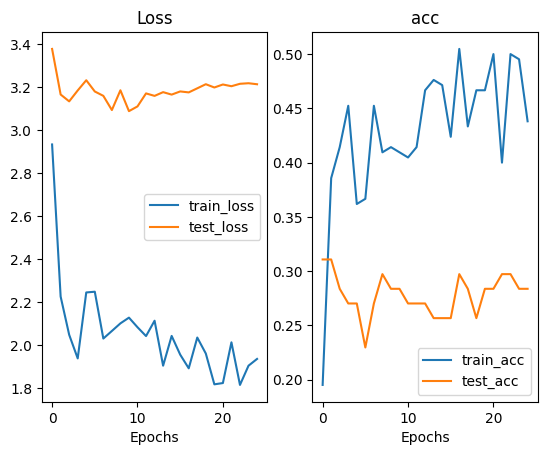

In [ ]:
train_acc = results["train_acc"]
test_acc = results["test_acc"]
train_loss = results["train_loss"]
test_loss = results["test_loss"]
epochs = range(len(results["train_loss"]))


plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label="train_loss")
plt.plot(epochs, test_loss, label = "test_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend();

plt.subplot(1,2,2)
plt.plot(epochs, train_acc, label="train_acc")
plt.plot(epochs, test_acc, label = "test_acc")
plt.title("acc")
plt.xlabel("Epochs")
plt.legend();


In [ ]:
# See if required packages arre installed and if not, install them
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1] >= 19, "mlxtend version should be 0.19.0 or higher")
except:
  !pip install torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Unins

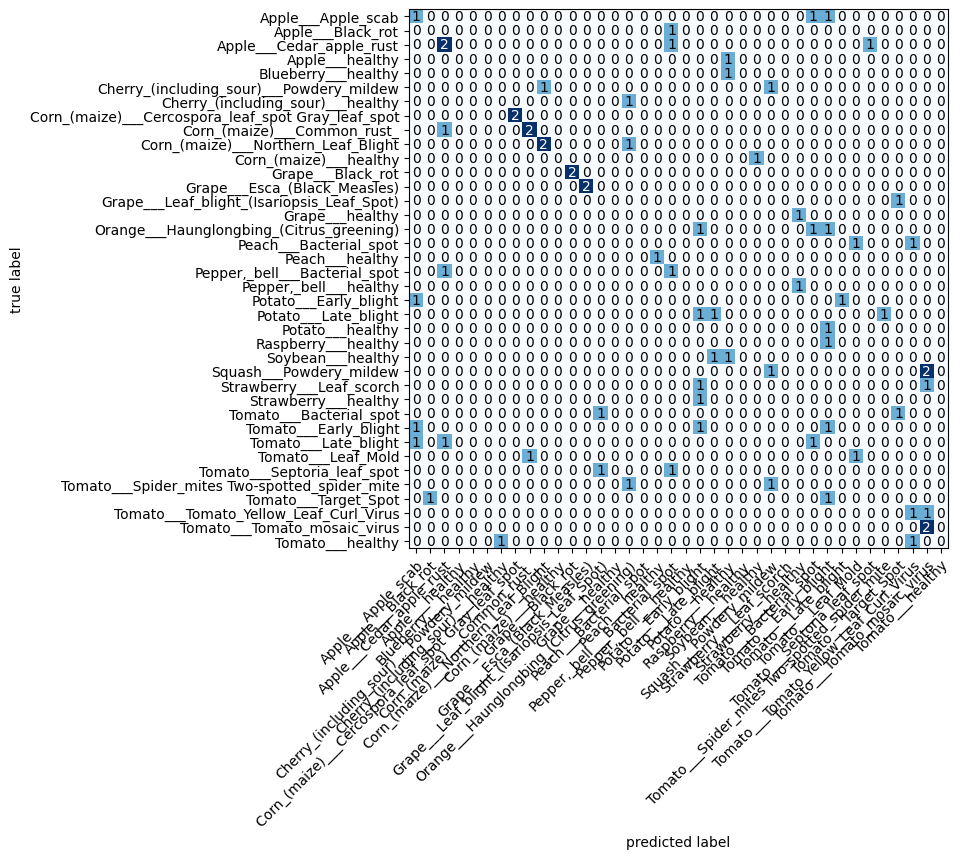

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and ccompare predictions to targets
confmat = ConfusionMatrix(num_classes = len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=(torch.tensor(test_data.targets)).squeeze())

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), # matplotlib likes working with numpy
                                class_names=class_names,
                                figsize=(10, 7))

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=aa4b36dac934d5118a9cff934a8ec69e9f141a130dee4c817fa1d3648b67a491
  Stored in directory: /root/.cache/pip/wheels/bc/52/78/893c3b94279ef238f43a9e89608af648de401b96415bebbd1f
Successfully built grad-cam


Input shape: torch.Size([1, 3, 224, 224])
Predicted class: Apple___Cedar_apple_rust


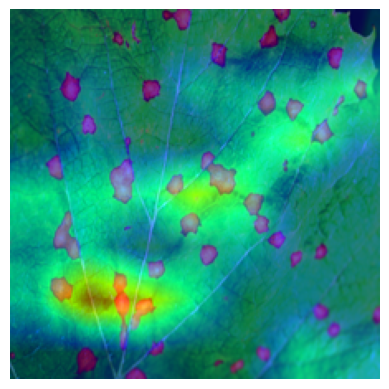

In [ ]:
model_loaded.eval()
from PIL import Image


image_path = Path("ReadWorldTest/test/Grape___Black_rot/6-14-11 ANNEMIEK blkRotSp.jpg")
image = Image.open(image_path).convert("RGB")
transform = transforms.Compose([transforms.Resize(size=(224,224)),
                                transforms.ToTensor()])

input_tensor=transform(image).unsqueeze(0)
print(f"Input shape: {input_tensor.shape}")

y_logits_test = model_loaded(input_tensor.to(device))

print(f"Predicted class: {class_names[y_logits_test.argmax(dim=1)]}")
#print(f"Probability: {(torch.softmax(y_logits_test, dim=1))[y_logits_test.argmax(dim=1)]}")

input_tensor.to(device)

import numpy as np
import matplotlib.pyplot as plt
# Original image must be in [0,1] for overlay
rgb_img = np.array(image.resize((224, 224))).astype(np.float32) / 255.0

plt.imshow(rgb_img)
plt.axis(False);

from torchvision.models import resnet18
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layer = model_loaded.layer4[-1]
gradcam = GradCAMPlusPlus(model_loaded, target_layers=[target_layer])

grayscale_cam = gradcam(input_tensor=input_tensor, targets=None, aug_smooth=True, eigen_smooth=True)
grayscale_cam = grayscale_cam[0]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

import matplotlib.pyplot as plt

plt.imshow(rgb_img)

plt.imshow(visualization)
plt.axis(False)
plt.show()

In [ ]:
split_dataset_path = "/content/ReadWorldTest"
backup_path = '/content/drive/My Drive/ML_Backups'

import shutil

shutil.copytree(split_dataset_path, backup_path, dirs_exist_ok=True)

'/content/drive/My Drive/ML_Backups'

# Freezing/unfreezing

In [ ]:
for param in model_loaded.parameters():
  param.requires_grad = False

# re-enabling this layer
model_loaded.fc = nn.Linear(model_loaded.fc.in_features, 38)
# print(model_loaded.fc.in_features) #output = 512

model_loaded.to(device)

512


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
device= "cuda" if torch.cuda.is_available() else "cpu"

# Only the new fc layer will be updated during training since it’s the only one with requires_grad = True
from torch import nn
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(lr=1e-4, params=model_loaded.fc.parameters(), weight_decay=1e-4)
#By default, the new nn.Linear(...) layer has requires_grad = True

scheduler = ReduceLROnPlateau(optimizer,
                              mode="min", # because we're monitoring validation loss
                              patience=3, # wait 3 epochs before reducing
                              factor=0.5, # halve the LR
                              verbose=True)  # print update
# scheduler = OneCycleLR(optimizer, epochs=8, max_lr=0.01, steps_per_epoch=len(train_dataloader)) # halvve LR every 5 epochs

from tqdm.auto import tqdm

# Measure time
from timeit import default_timer as timer
start_time = timer()

torch.manual_seed(42)

epochs = 50

model_loaded.train()

results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

for epoch in tqdm(range(epochs)):
  y_preds= []
  train_loss, train_acc = 0, 0
  test_loss, test_acc = 0,0
  print(f"Epoch: {epoch}\n---------")
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)
    y_logits = model_loaded(X)
    loss = loss_fn(y_logits, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_labels = y_logits.argmax(dim=1)
    train_acc += (y_labels==y).sum().item()/len(y_logits)

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  model_loaded.eval()

  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(test_dataloader):
      X_test, y_test = X_test.to(device), y_test.to(device)
      test_y_logits = model_loaded(X_test)
      loss = loss_fn(test_y_logits, y_test)
      test_loss += loss.item()

      test_y_labels = test_y_logits.argmax(dim=1)
      y_preds.append(test_y_labels.cpu())
      test_acc += (test_y_labels == y_test).sum().item()/len(test_y_logits)
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

    scheduler.step(test_loss)

    print(f"Train Loss: {train_loss} | Train Acc: {train_acc}")
    print(f"Test Loss: {test_loss} | Test Acc: {test_acc}")

  y_pred_tensor = (torch.cat(y_preds))
  results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
  results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
  results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
  results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.657569980621338 | Train Acc: 0.014285714285714285
Test Loss: 3.6081228513975403 | Test Acc: 0.04054054054054054
Epoch: 1
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.584513132912772 | Train Acc: 0.0380952380952381
Test Loss: 3.569258380580593 | Test Acc: 0.05405405405405406
Epoch: 2
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.522326001666841 | Train Acc: 0.07142857142857142
Test Loss: 3.5384253553442053 | Test Acc: 0.05405405405405406
Epoch: 3
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.4761650834764755 | Train Acc: 0.06190476190476191
Test Loss: 3.5114200566266036 | Test Acc: 0.06756756756756757
Epoch: 4
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.457250838052659 | Train Acc: 0.07142857142857142
Test Loss: 3.4909460093524003 | Test Acc: 0.06756756756756757
Epoch: 5
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.4289246377490814 | Train Acc: 0.08571428571428572
Test Loss: 3.4753383108087488 | Test Acc: 0.05405405405405406
Epoch: 6
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.4098895277295793 | Train Acc: 0.0761904761904762
Test Loss: 3.458080414179209 | Test Acc: 0.08108108108108109
Epoch: 7
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.391205356234596 | Train Acc: 0.08095238095238096
Test Loss: 3.440010167456962 | Test Acc: 0.08108108108108109
Epoch: 8
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.3686299823579335 | Train Acc: 0.07142857142857142
Test Loss: 3.4277829608401738 | Test Acc: 0.08108108108108109
Epoch: 9
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.3465081078665597 | Train Acc: 0.09047619047619047
Test Loss: 3.4108910625045366 | Test Acc: 0.08108108108108109
Epoch: 10
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.3229669139498754 | Train Acc: 0.09047619047619047
Test Loss: 3.396317140476124 | Test Acc: 0.0945945945945946
Epoch: 11
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.3057590234847294 | Train Acc: 0.10952380952380952
Test Loss: 3.3824865882461137 | Test Acc: 0.14864864864864866
Epoch: 12
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.306732229959397 | Train Acc: 0.11428571428571428
Test Loss: 3.366661142658543 | Test Acc: 0.14864864864864866
Epoch: 13
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.25182881582351 | Train Acc: 0.1380952380952381
Test Loss: 3.3504313842670337 | Test Acc: 0.13513513513513514
Epoch: 14
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.251522752216884 | Train Acc: 0.13333333333333333
Test Loss: 3.3363357621270255 | Test Acc: 0.14864864864864866
Epoch: 15
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.227878207252139 | Train Acc: 0.18095238095238095
Test Loss: 3.3225100104873246 | Test Acc: 0.14864864864864866
Epoch: 16
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.191500557036627 | Train Acc: 0.14285714285714285
Test Loss: 3.3057663247391984 | Test Acc: 0.14864864864864866
Epoch: 17
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.2020575046539306 | Train Acc: 0.1619047619047619
Test Loss: 3.2908381449209676 | Test Acc: 0.17567567567567569
Epoch: 18
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.1973713193620954 | Train Acc: 0.22380952380952382
Test Loss: 3.2811381816864014 | Test Acc: 0.17567567567567569
Epoch: 19
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.1251865772973924 | Train Acc: 0.1761904761904762
Test Loss: 3.269637835992349 | Test Acc: 0.1891891891891892
Epoch: 20
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.121851986930484 | Train Acc: 0.19523809523809524
Test Loss: 3.2554324059873014 | Test Acc: 0.21621621621621623
Epoch: 21
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.1382936523074196 | Train Acc: 0.16666666666666666
Test Loss: 3.2451172648249447 | Test Acc: 0.20270270270270271
Epoch: 22
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.0889386971791586 | Train Acc: 0.20952380952380953
Test Loss: 3.2312182413565145 | Test Acc: 0.21621621621621623
Epoch: 23
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.116086230959211 | Train Acc: 0.1761904761904762
Test Loss: 3.2211862061474776 | Test Acc: 0.22972972972972974
Epoch: 24
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.0752275693984257 | Train Acc: 0.21428571428571427
Test Loss: 3.2091011421100513 | Test Acc: 0.24324324324324326
Epoch: 25
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.1058812799907867 | Train Acc: 0.2
Test Loss: 3.2012094259262085 | Test Acc: 0.20270270270270271
Epoch: 26
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.0472946439470565 | Train Acc: 0.23333333333333334
Test Loss: 3.1914114694337585 | Test Acc: 0.21621621621621623
Epoch: 27
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.046968005952381 | Train Acc: 0.21904761904761905
Test Loss: 3.181443523716282 | Test Acc: 0.21621621621621623
Epoch: 28
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.0721932706378756 | Train Acc: 0.24761904761904763
Test Loss: 3.1733387225383036 | Test Acc: 0.21621621621621623
Epoch: 29
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.0336735407511393 | Train Acc: 0.22857142857142856
Test Loss: 3.165588723646628 | Test Acc: 0.22972972972972974
Epoch: 30
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.012097490401495 | Train Acc: 0.22380952380952382
Test Loss: 3.1588915489815377 | Test Acc: 0.22972972972972974
Epoch: 31
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.0221180518468223 | Train Acc: 0.23809523809523808
Test Loss: 3.1510162546827987 | Test Acc: 0.22972972972972974
Epoch: 32
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.9577009541647774 | Train Acc: 0.2571428571428571
Test Loss: 3.1396563053131104 | Test Acc: 0.22972972972972974
Epoch: 33
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.986238938286191 | Train Acc: 0.23333333333333334
Test Loss: 3.1326761213508814 | Test Acc: 0.22972972972972974
Epoch: 34
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.9821156740188597 | Train Acc: 0.2619047619047619
Test Loss: 3.124167854721482 | Test Acc: 0.21621621621621623
Epoch: 35
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.9724944205511186 | Train Acc: 0.22380952380952382
Test Loss: 3.1185250346725053 | Test Acc: 0.21621621621621623
Epoch: 36
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.945358980269659 | Train Acc: 0.26666666666666666
Test Loss: 3.1102438746271908 | Test Acc: 0.22972972972972974
Epoch: 37
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.920985476175944 | Train Acc: 0.2619047619047619
Test Loss: 3.10452075906702 | Test Acc: 0.21621621621621623
Epoch: 38
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.893526160149347 | Train Acc: 0.28095238095238095
Test Loss: 3.098328999570898 | Test Acc: 0.21621621621621623
Epoch: 39
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.9587385677155993 | Train Acc: 0.23333333333333334
Test Loss: 3.0939530005326144 | Test Acc: 0.22972972972972974
Epoch: 40
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.9048928601401194 | Train Acc: 0.23809523809523808
Test Loss: 3.085045495548764 | Test Acc: 0.22972972972972974
Epoch: 41
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.8843551726568313 | Train Acc: 0.24761904761904763
Test Loss: 3.076800736221107 | Test Acc: 0.21621621621621623
Epoch: 42
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.970540310087658 | Train Acc: 0.22857142857142856
Test Loss: 3.0681105046658903 | Test Acc: 0.21621621621621623
Epoch: 43
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.840169722693307 | Train Acc: 0.24761904761904763
Test Loss: 3.060988281224225 | Test Acc: 0.22972972972972974
Epoch: 44
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.918772742861793 | Train Acc: 0.22380952380952382
Test Loss: 3.0558758394138232 | Test Acc: 0.25675675675675674
Epoch: 45
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.838833224205744 | Train Acc: 0.2904761904761905
Test Loss: 3.0502023696899414 | Test Acc: 0.25675675675675674
Epoch: 46
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.8789055949165707 | Train Acc: 0.24761904761904763
Test Loss: 3.043732855771039 | Test Acc: 0.24324324324324326
Epoch: 47
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.8372873181388494 | Train Acc: 0.26666666666666666
Test Loss: 3.03647222390046 | Test Acc: 0.22972972972972974
Epoch: 48
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.8380232822327387 | Train Acc: 0.2619047619047619
Test Loss: 3.0343498732592606 | Test Acc: 0.22972972972972974
Epoch: 49
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.836157402538118 | Train Acc: 0.23333333333333334
Test Loss: 3.0290748460872754 | Test Acc: 0.24324324324324326
Total training time: 183.306 seconds


In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models_fc")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "fc+RealWorld+PlantVillageModelV6.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_loaded.state_dict(), f = MODEL_SAVE_PATH)

Saving model to: models_fc/fc+RealWorld+PlantVillageModelV6.pth


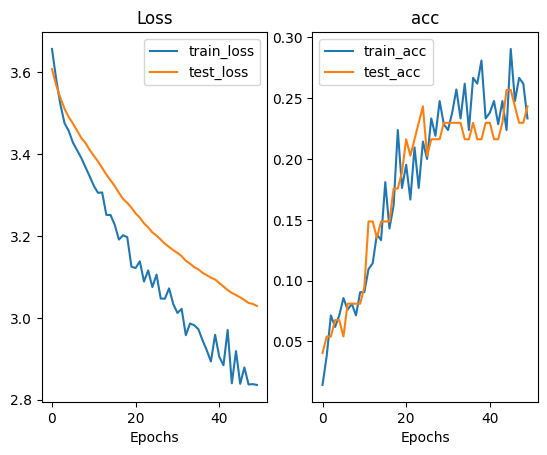

In [ ]:
train_acc = results["train_acc"]
test_acc = results["test_acc"]
train_loss = results["train_loss"]
test_loss = results["test_loss"]
epochs = range(len(results["train_loss"]))


plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label="train_loss")
plt.plot(epochs, test_loss, label = "test_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend();

plt.subplot(1,2,2)
plt.plot(epochs, train_acc, label="train_acc")
plt.plot(epochs, test_acc, label = "test_acc")
plt.title("acc")
plt.xlabel("Epochs")
plt.legend();

# Unfreeze deep layers

In [ ]:
import torch
from torchvision.models import resnet18
device = "cuda" if torch.cuda.is_available() else "cpu"
model_loaded_1 = resnet18(weights=None)
model_loaded_1.fc = torch.nn.Linear(in_features=512, out_features=38)
model_loaded_1.load_state_dict(torch.load("models_fc/fc+RealWorld+PlantVillageModelV6.pth"))
model_loaded_1.eval()
model_loaded_1.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for name, param in model_loaded_1.named_parameters():
  if "layer4" in name or "layer3" in name or "fc" in name:
    param.requires_grad = True
  else:
    param.requires_grad = False

model_loaded_1.fc = nn.Linear(model_loaded_1.fc.in_features, 38)
model_loaded_1.to(device)
print(model_loaded_1.fc)

Linear(in_features=512, out_features=38, bias=True)


In [ ]:
device= "cuda" if torch.cuda.is_available() else "cpu"

# Only the new fc, layer3 and layer4 layers will be updated during training since it’s the only one with requires_grad = True
from torch import nn
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
loss_fn = nn.CrossEntropyLoss()

#optimizer = torch.optim.Adam(lr=1e-4, params=model_loaded.fc.parameters(), weight_decay=1e-4)

optimizer = torch.optim.Adam([{"params": model_loaded_1.fc.parameters(), "lr": 1e-3},
                              {"params": model_loaded_1.layer3.parameters(), "lr": 1e-4},
                              {"params": model_loaded_1.layer4.parameters(), "lr": 1e-4}
                              ]) # use a smaller lr to avoid wrecking the pre-trained weights

scheduler_1 = ReduceLROnPlateau(optimizer,
                              mode="min", # because we're monitoring validation loss
                              patience=3, # wait 3 epochs before reducing
                              factor=0.5, # halve the LR
                              verbose=True)  # print update
# scheduler = OneCycleLR(optimizer, epochs=8, max_lr=0.01, steps_per_epoch=len(train_dataloader)) # halvve LR every 5 epochs

from tqdm.auto import tqdm

# Measure time
from timeit import default_timer as timer
start_time = timer()

torch.manual_seed(42)

epochs = 50

model_loaded_1.train()

results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

for epoch in tqdm(range(epochs)):
  y_preds= []
  train_loss, train_acc = 0, 0
  test_loss, test_acc = 0,0
  print(f"Epoch: {epoch}\n---------")
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)
    y_logits = model_loaded_1(X)
    loss = loss_fn(y_logits, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_labels = y_logits.argmax(dim=1)
    train_acc += (y_labels==y).sum().item()/len(y_logits)

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  model_loaded_1.eval()

  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(test_dataloader):
      X_test, y_test = X_test.to(device), y_test.to(device)
      test_y_logits = model_loaded_1(X_test)
      loss = loss_fn(test_y_logits, y_test)
      test_loss += loss.item()

      test_y_labels = test_y_logits.argmax(dim=1)
      y_preds.append(test_y_labels.cpu())
      test_acc += (test_y_labels == y_test).sum().item()/len(test_y_logits)
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

    scheduler_1.step(test_loss)

    print(f"Train Loss: {train_loss} | Train Acc: {train_acc}")
    print(f"Test Loss: {test_loss} | Test Acc: {test_acc}")

  y_pred_tensor = (torch.cat(y_preds))
  results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
  results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
  results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
  results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.744812436330886 | Train Acc: 0.05714285714285714
Test Loss: 3.444293476439811 | Test Acc: 0.12162162162162163
Epoch: 1
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.255558138801938 | Train Acc: 0.08095238095238096
Test Loss: 3.1560527440663932 | Test Acc: 0.16216216216216217
Epoch: 2
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.8940533967245194 | Train Acc: 0.23333333333333334
Test Loss: 2.998579477941668 | Test Acc: 0.20270270270270271
Epoch: 3
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.634270959808713 | Train Acc: 0.24761904761904763
Test Loss: 2.957031515804497 | Test Acc: 0.2972972972972973
Epoch: 4
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.7228867956570215 | Train Acc: 0.2619047619047619
Test Loss: 2.965781008875048 | Test Acc: 0.25675675675675674
Epoch: 5
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.689929318144208 | Train Acc: 0.24761904761904763
Test Loss: 3.0851101432297683 | Test Acc: 0.20270270270270271
Epoch: 6
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.496791250365121 | Train Acc: 0.3
Test Loss: 3.044002723049473 | Test Acc: 0.24324324324324326
Epoch: 7
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.5030833851723444 | Train Acc: 0.2904761904761905
Test Loss: 2.9815987243845656 | Test Acc: 0.25675675675675674
Epoch: 8
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.4230406094165073 | Train Acc: 0.2857142857142857
Test Loss: 3.135844219778035 | Test Acc: 0.1891891891891892
Epoch: 9
---------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.390083132471357 | Train Acc: 0.3523809523809524
Test Loss: 2.9876646544482255 | Test Acc: 0.28378378378378377
Total training time: 42.126 seconds


In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models_fc+layer3+layer4")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "fc+layer3+layer4+RealWorld+PlantVillageModelV6.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_loaded.state_dict(), f = MODEL_SAVE_PATH)

Saving model to: models_fc+layer3+layer4/fc+layer3+layer4+RealWorld+PlantVillageModelV6.pth


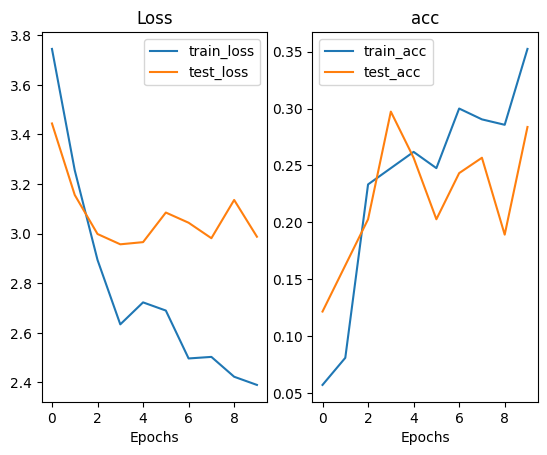

In [ ]:
train_acc = results["train_acc"]
test_acc = results["test_acc"]
train_loss = results["train_loss"]
test_loss = results["test_loss"]
epochs = range(len(results["train_loss"]))


plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label="train_loss")
plt.plot(epochs, test_loss, label = "test_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend();

plt.subplot(1,2,2)
plt.plot(epochs, train_acc, label="train_acc")
plt.plot(epochs, test_acc, label = "test_acc")
plt.title("acc")
plt.xlabel("Epochs")
plt.legend();